# This script is used for the online course "资金流入流出" in Tianchi platform

                                                                           Author: Chuan-yu Xue
                                                                           Email: cs_xcy@126.com

注，此处所有的金额单位都是分，例如用户某日买入100万，代表其购买了1万

In [1]:
import pandas as  pd
import numpy as np
import warnings 
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Load the balance data
data_balance = pd.read_csv('Dataset/user_balance_table.csv')

# add tiemstamp to dataset
data_balance['date'] = pd.to_datetime(data_balance['report_date'], format= "%Y%m%d")
data_balance['day'] = data_balance['date'].dt.day
data_balance['month'] = data_balance['date'].dt.month
data_balance['year'] = data_balance['date'].dt.year
data_balance['week'] = data_balance['date'].dt.week
data_balance['weekday'] = data_balance['date'].dt.weekday

# total amount
total_balance = data_balance.groupby(['date'])['total_purchase_amt','total_redeem_amt'].sum()
total_balance.reset_index(inplace=True)

# Add time stamp
total_balance['day'] = total_balance['date'].dt.day
total_balance['month'] = total_balance['date'].dt.month
total_balance['year'] = total_balance['date'].dt.year
total_balance['week'] = total_balance['date'].dt.week
total_balance['weekday'] = total_balance['date'].dt.weekday

# Load user's information
users = pd.read_csv('Dataset/user_profile_table.csv')

## 一、分析大小额用户

前面的分析可以看出，某些用户的交易额很大，对于日交易量很明显，这里统计四月份后依旧活跃的大额用户(大于100万)

In [4]:
# 获得大额用户的集合

temp = data_balance[(data_balance['total_purchase_amt'] >= 1000000) | (data_balance['total_redeem_amt'] >= 1000000)]
big_users_set = set(temp[temp['date'] >= datetime.datetime(2014,4,1)]['user_id'])

In [5]:
len(big_users_set)

3903

In [6]:
max(data_balance['user_id'])

28041

大额用户占3903个，占总数的13%

In [7]:
# 标记大额用户

data_balance['big_user'] = 0
data_balance.loc[data_balance['user_id'].isin(big_users_set), 'big_user'] = 1

In [8]:
# 统计大额用户与小额用户的日总交易额的区别

total_balance_bigNsmall = data_balance.groupby(['date','big_user'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()

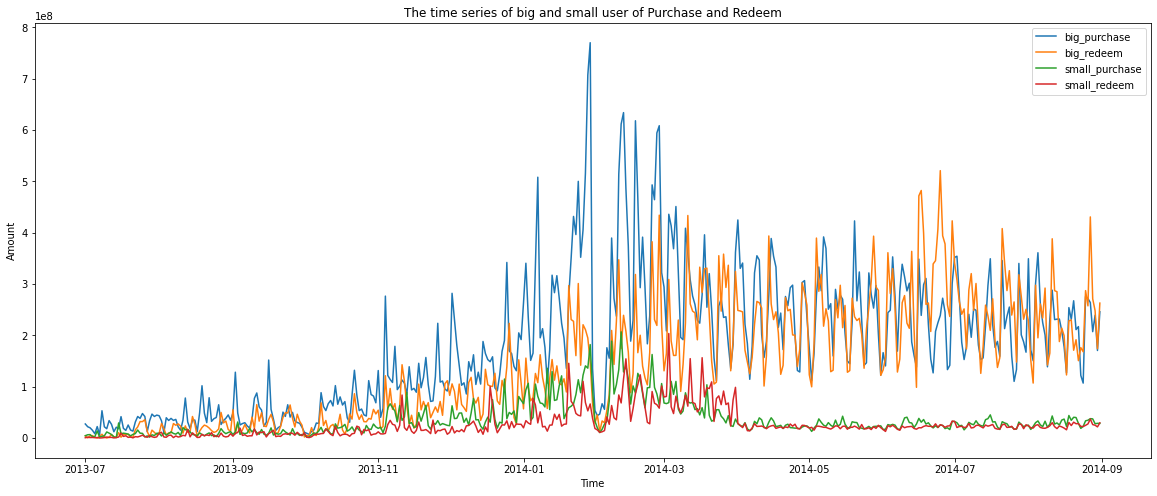

In [9]:
# 画出大额用户与小额用户交易的日总交易量图

fig = plt.figure(figsize=(20,8))
plt.plot(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['date'], total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['total_purchase_amt'],label='big_purchase')
plt.plot(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['date'], total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['total_redeem_amt'],label='big_redeem')

plt.plot(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['date'], total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['total_purchase_amt'],label='small_purchase')
plt.plot(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['date'], total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['total_redeem_amt'],label='small_redeem')
plt.legend(loc='best')
plt.title("The time series of big and small user of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

In [10]:
# 统计大额小额用户购买量占比

np.sum(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['total_purchase_amt']) / np.sum(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['total_purchase_amt'])

5.1456178397775805

In [11]:
# 统计大额小额用户赎回量占比

np.sum(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 1]['total_redeem_amt']) / np.sum(total_balance_bigNsmall[total_balance_bigNsmall['big_user'] == 0]['total_redeem_amt'])

5.422141272341089

## 二、分析用户的交易频次

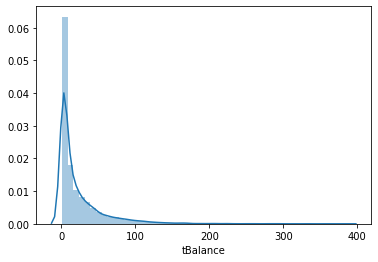

In [13]:
# 画出非0交易的分布图

frequency = data_balance[(data_balance['direct_purchase_amt'] != 0) | (data_balance['total_redeem_amt'] != 0)][['user_id','tBalance']].groupby('user_id', as_index=False).count()
sns.distplot(frequency['tBalance'])

In [14]:
# 获取频繁交易用户集合

hot_users_set = set(frequency[frequency['tBalance'] > 30]['user_id'])

In [15]:
# 获取频繁用户的交易纪录

data_balance['is_hot_users'] = 0
data_balance.loc[data_balance['user_id'].isin(hot_users_set) , 'is_hot_users'] = 1

In [16]:
# 统计频繁用户与非频繁用户的日总交易额的区别

total_balance_hotNcold = data_balance.groupby(['date','is_hot_users'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()

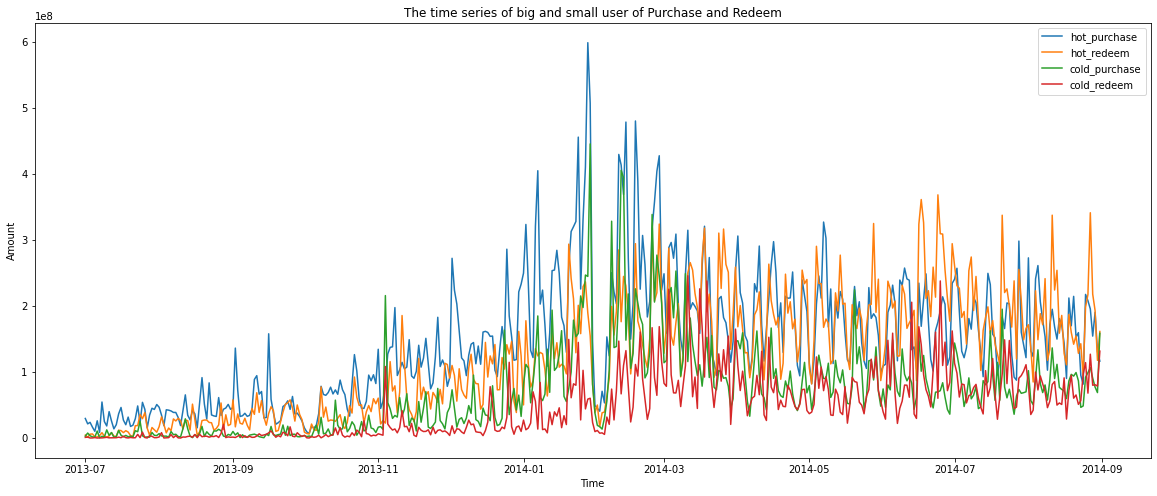

In [17]:
# 绘制频繁用户与非频繁用户总购买赎回量的时序图

fig = plt.figure(figsize=(20,8))
plt.plot(total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 1]['date'], total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 1]['total_purchase_amt'],label='hot_purchase')
plt.plot(total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 1]['date'], total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 1]['total_redeem_amt'],label='hot_redeem')

plt.plot(total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 0]['date'], total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 0]['total_purchase_amt'],label='cold_purchase')
plt.plot(total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 0]['date'], total_balance_hotNcold[total_balance_hotNcold['is_hot_users'] == 0]['total_redeem_amt'],label='cold_redeem')
plt.legend(loc='best')
plt.title("The time series of big and small user of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

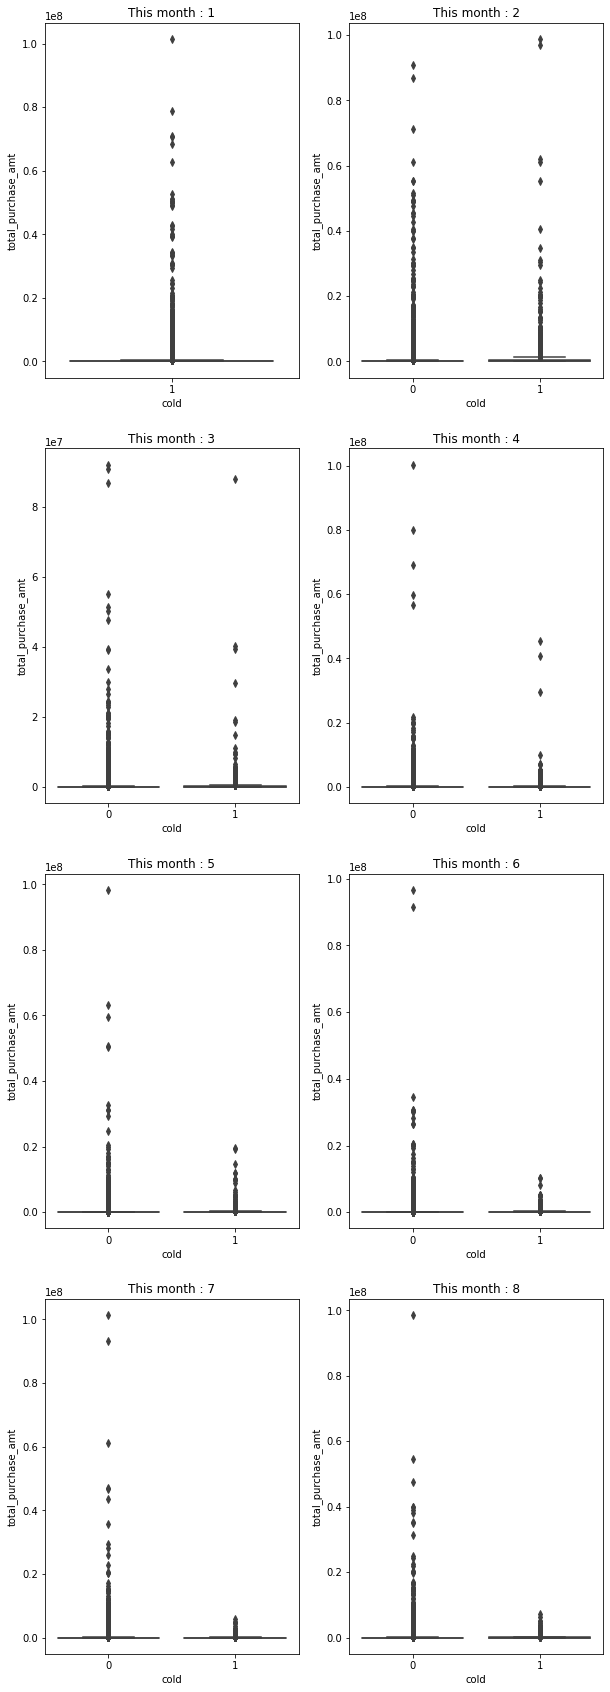

In [18]:
# 画出冷启动用户与老用户交易的箱型图

temp = data_balance[['year','month','user_id','total_purchase_amt','total_redeem_amt']].groupby(['year','month','user_id'], as_index=False).sum()
user_old_set = set()
plt.figure(figsize=(10,30))
for i in range(1, 9):
    newset = set(temp[(temp['year'] == 2014) & (temp['month'] == i)]['user_id'])
    this_month = data_balance[(data_balance['year'] == 2014) & (data_balance['month'] == i)]
    this_month['cold'] = 0
    this_month.loc[this_month['user_id'].isin(newset - user_old_set), 'cold'] = 1
    plt.subplot(4,2,i)
    plt.title('This month : ' + str(i))
    sns.boxplot(x="cold", y="total_purchase_amt" , data=this_month[(this_month['direct_purchase_amt'] != 0) | (this_month['total_redeem_amt'] != 0)])
    user_old_set = user_old_set | newset
plt.show()

## 三、分析用户的其他属性

In [19]:
# 用户的其他属性

users.head()

,user_id,sex,city,constellation
0,2,1,6411949,狮子座
1,12,1,6412149,摩羯座
2,22,1,6411949,双子座
3,23,1,6411949,双鱼座
4,25,1,6481949,双鱼座


In [20]:
# 添加城市、星座、性别

data_balance = pd.merge(data_balance, users, on='user_id')

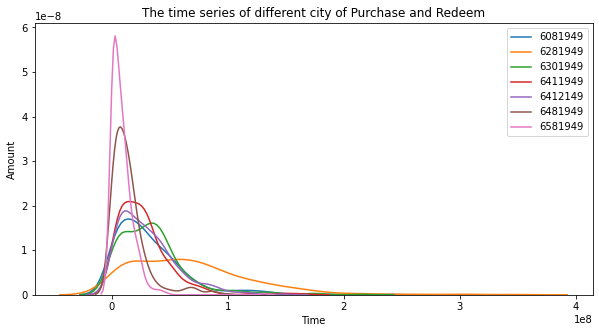

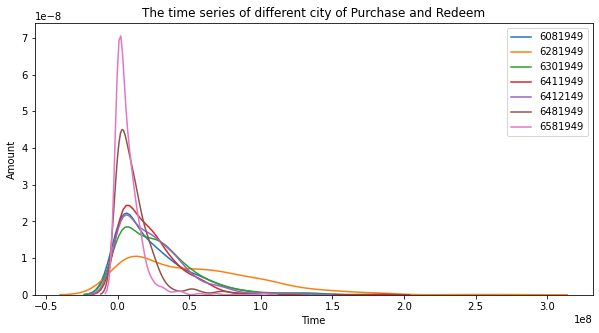

In [21]:
# 统计每个城市用户的日总交易额的区别并绘制分布估计图

fig = plt.figure(figsize=(10,5))
for i in np.unique(data_balance['city']):
    temp = data_balance.groupby(['date','city'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()
    ax = sns.kdeplot( temp[temp['city'] == i]['total_purchase_amt'],label=i)
plt.legend(loc='best')
plt.title("The time series of different city of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

fig = plt.figure(figsize=(10,5))
for i in np.unique(data_balance['city']):
    temp = data_balance.groupby(['date','city'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()
    ax = sns.kdeplot( temp[temp['city'] == i]['total_redeem_amt'],label=i)
plt.legend(loc='best')
plt.title("The time series of different city of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

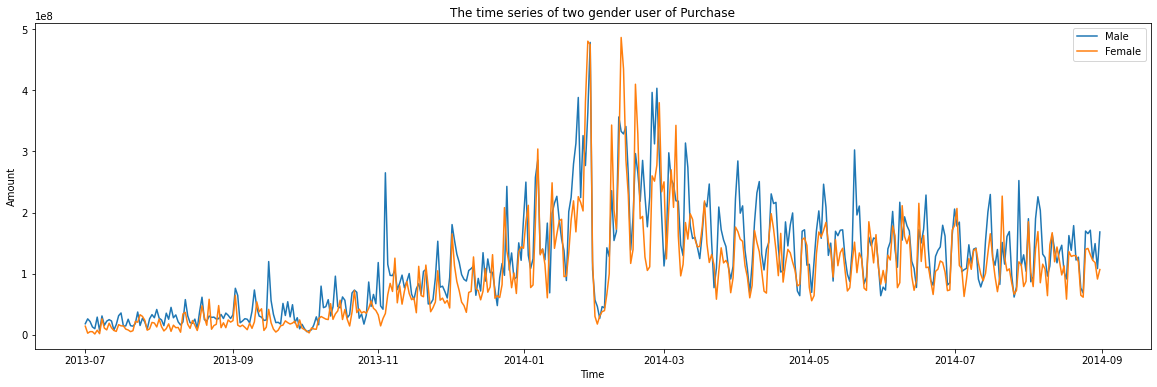

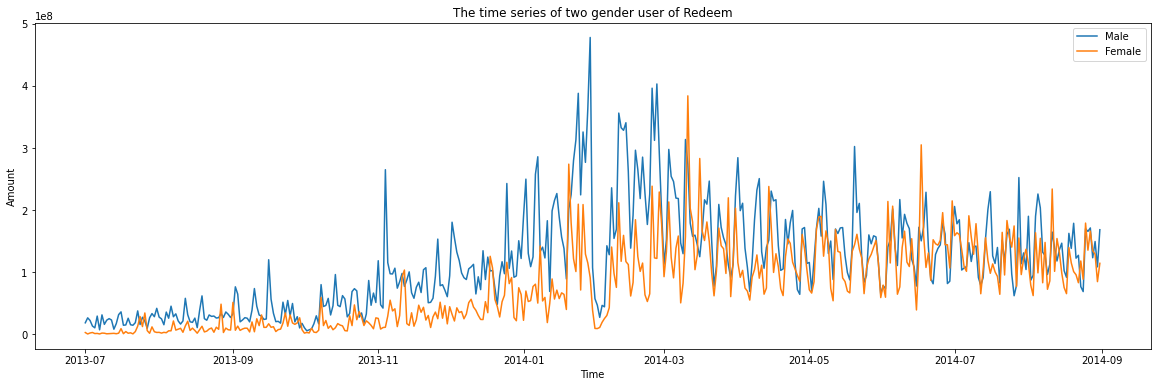

In [22]:
# 统计每个性别用户的日总交易额的区别，并绘制时序图

temp = data_balance.groupby(['date','sex'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()

fig = plt.figure(figsize=(20,6))
plt.plot(temp[temp['sex'] == 1]['date'], temp[temp['sex'] == 1]['total_purchase_amt'],label='Male')
plt.plot(temp[temp['sex'] == 0]['date'], temp[temp['sex'] == 0]['total_purchase_amt'],label='Female')
plt.legend(loc='best')
plt.title("The time series of two gender user of Purchase")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

fig = plt.figure(figsize=(20,6))
plt.plot(temp[temp['sex'] == 1]['date'], temp[temp['sex'] == 1]['total_purchase_amt'],label='Male')
plt.plot(temp[temp['sex'] == 0]['date'], temp[temp['sex'] == 0]['total_redeem_amt'],label='Female')
plt.legend(loc='best')
plt.title("The time series of two gender user of Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

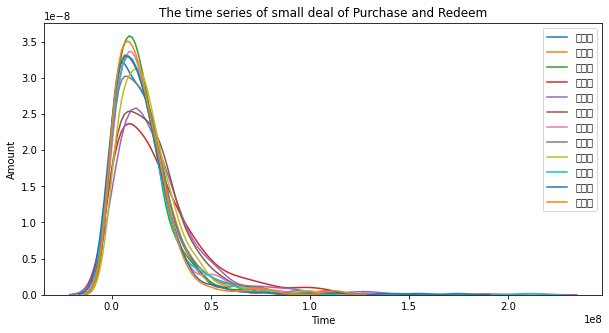

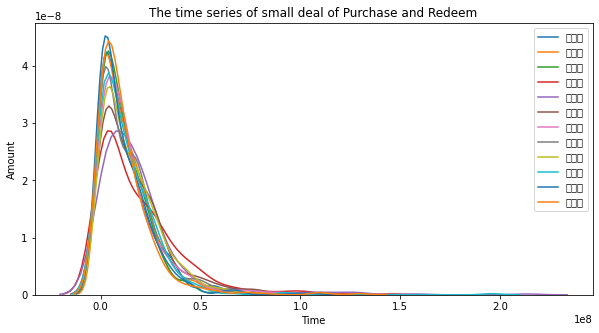

In [23]:
# 统计每个星座用户的日总交易额的区别 并绘制分布估计图

fig = plt.figure(figsize=(10,5))
for i in np.unique(data_balance['constellation']):
    temp = data_balance.groupby(['date','constellation'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()
    ax = sns.kdeplot( temp[temp['constellation'] == i]['total_purchase_amt'],label=i)
plt.legend(loc='best')
plt.title("The time series of small deal of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

fig = plt.figure(figsize=(10,5))
for i in np.unique(data_balance['constellation']):
    temp = data_balance.groupby(['date','constellation'], as_index=False)['total_purchase_amt','total_redeem_amt'].sum()
    ax = sns.kdeplot( temp[temp['constellation'] == i]['total_redeem_amt'],label=i)
plt.legend(loc='best')
plt.title("The time series of small deal of Purchase and Redeem")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

##  四、其他分析

In [24]:
# 统计每个性别用户的日总交易额的区别

temp = data_balance.groupby(['date'], as_index=False)['direct_purchase_amt','share_amt'].sum()

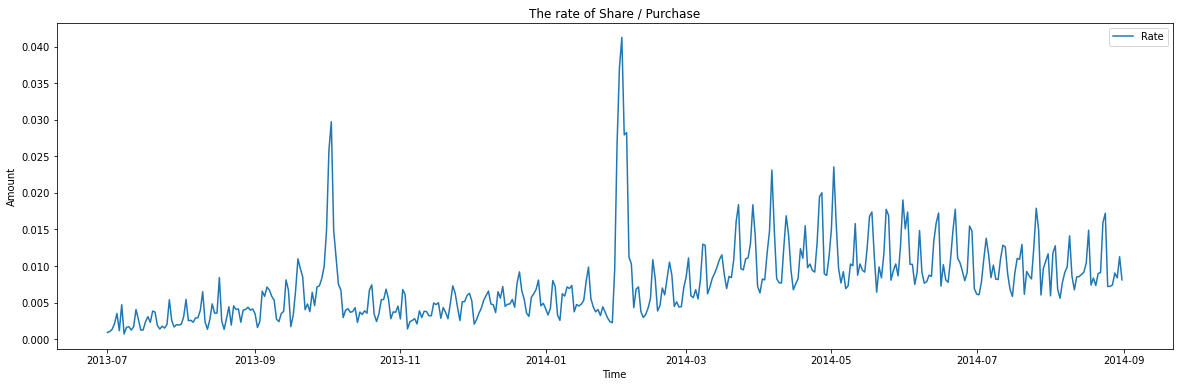

In [25]:
# 画出每日利息的增长/直接购买量的时序图

fig = plt.figure(figsize=(20,6))
plt.plot(temp['date'],  temp['share_amt'] / temp['direct_purchase_amt'] ,label='Rate')
plt.legend(loc='best')
plt.title("The rate of Share / Purchase")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

In [26]:
# 加载支付宝利率数据

share = pd.read_csv('Dataset/mfd_day_share_interest.csv')
share = share.rename(columns = {'mfd_date': 'date'})
share_features = [x for x in share.columns if x not in ['date']]
share['date'] = pd.to_datetime(share['date'], format= "%Y%m%d")
share['day'] = share['date'].dt.day
share['month'] = share['date'].dt.month
share['year'] = share['date'].dt.year
share['week'] = share['date'].dt.week
share['weekday'] = share['date'].dt.weekday

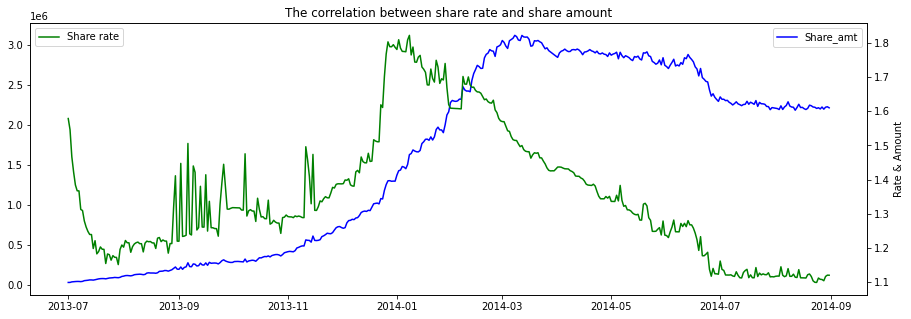

In [27]:
# 绘制支付宝利率与交易额的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(temp['date'], temp['share_amt'],'b',label="Share_amt")
plt.legend()

ax2=ax1.twinx()
plt.plot(share['date'], share['mfd_daily_yield'],'g',label="Share rate")

plt.legend(loc=2)
plt.title("The correlation between share rate and share amount")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")

plt.show()

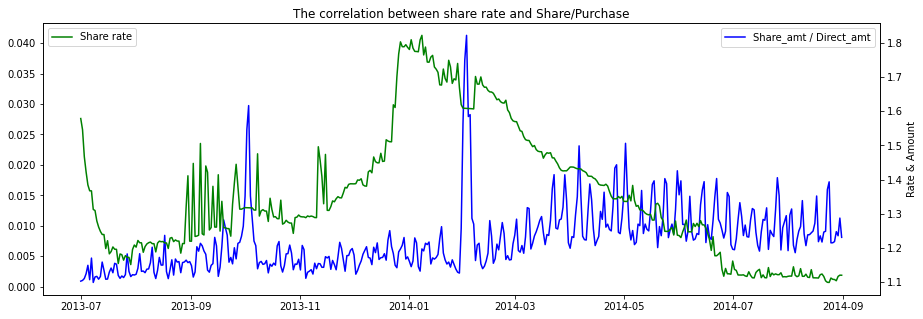

In [28]:
# 支付宝利率与每日利息的增长/直接购买量的时序图

fig,ax1 = plt.subplots(figsize=(15,5))
plt.plot(temp['date'], temp['share_amt'] / temp['direct_purchase_amt'],'b',label="Share_amt / Direct_amt")
plt.legend()

ax2=ax1.twinx()
plt.plot(share['date'], share['mfd_daily_yield'],'g',label="Share rate")

plt.legend(loc=2)
plt.title("The correlation between share rate and Share/Purchase")
plt.xlabel("Time")
plt.ylabel("Rate & Amount")

plt.show()

直接购买里面有两种
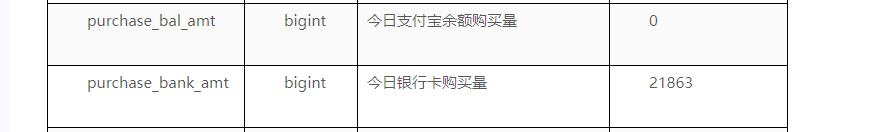

In [29]:
# 聚合两种不同购买方式

temp = data_balance.groupby(['date'], as_index=False)['purchase_bal_amt','purchase_bank_amt'].sum()

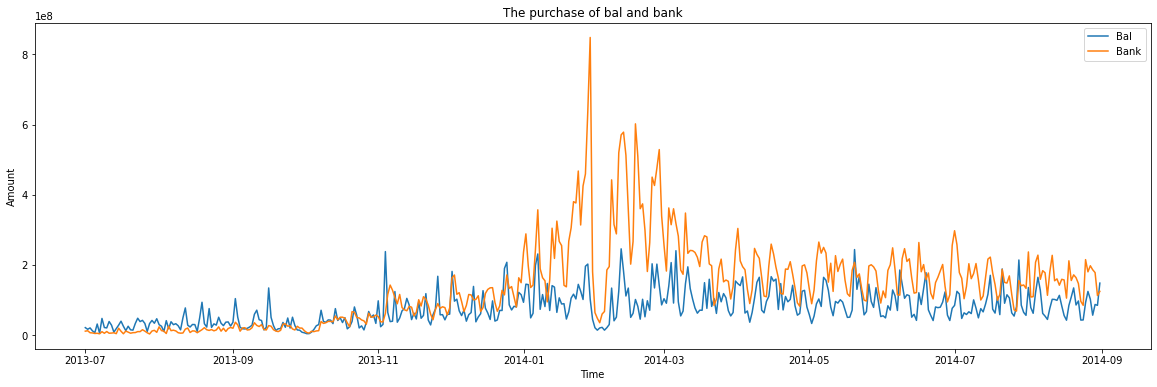

In [30]:
# 画出不同购买方式日购买量的时序图

fig = plt.figure(figsize=(20,6))
plt.plot(temp['date'], temp['purchase_bal_amt'],label='Bal')
plt.plot(temp['date'], temp['purchase_bank_amt'],label='Bank')
plt.legend(loc='best')
plt.title("The purchase of bal and bank")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

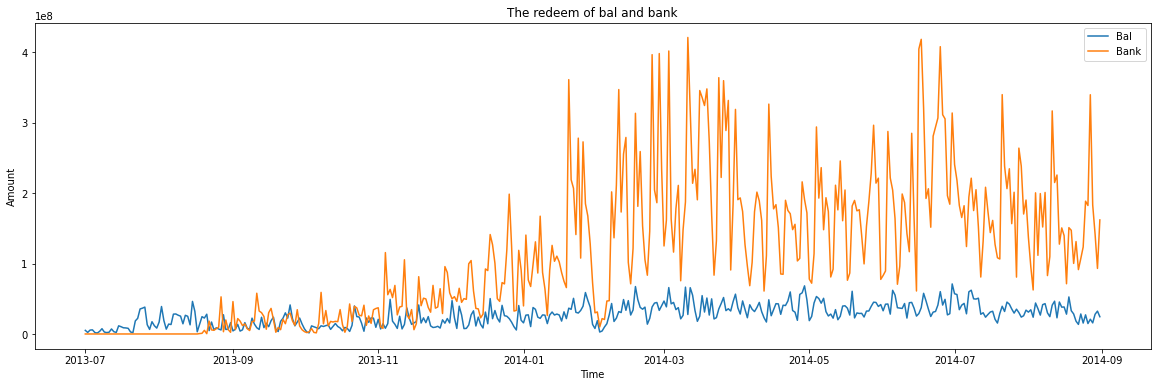

In [31]:
# 画出不同赎回方式日赎回量的时序图

temp = data_balance.groupby(['date'], as_index=False)['tftobal_amt','tftocard_amt'].sum()
fig = plt.figure(figsize=(20,6))
plt.plot(temp['date'], temp['tftobal_amt'],label='Bal')
plt.plot(temp['date'], temp['tftocard_amt'],label='Bank')
plt.legend(loc='best')
plt.title("The redeem of bal and bank")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.show()

虽然支付宝或者银行卡买入区别不大，但是redeem上的差异性相当明显。